# CLustering text documentss using kmeans
This is an example showing how the scikit-learn API can be used to cluster documents by topics using a Bag of Words approach.

Two algorithms are demonstrated, namely KMeans and its more scalable variant, MiniBatchKMeans. Additionally, latent semantic analysis is used to reduce dimensionality and discover latent patterns in the data.

This example uses two different text vectorizers: a TfidfVectorizer and a HashingVectorizer.

In [2]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")
print(list(dataset.target_names))

3387 documents - 4 categories
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


Clustering algorithms are fundamentally unsupervised learning methods. However, since we happen to have class labels for this specific dataset, it is possible to use evaluation metrics that leverage this “supervised” ground truth information to quantify the quality of the resulting clusters. Examples of such metrics are the following:

- **homogeneity**, which quantifies how much clusters contain only members of a single class;
- **completeness**, which quantifies how much members of a given class are assigned to the same clusters;
- **V-measure**, the harmonic mean of completeness and homogeneity;
- **Rand-Index**, which measures how frequently pairs of data points are grouped consistently according to the result of the clustering algorithm and the ground truth class assignment;
- **Adjusted Rand-Index**, a chance-adjusted Rand-Index such that random cluster assignment have an ARI of 0.0 in expectation.

If the ground truth labels are not known, evaluation can only be performed using the model results itself. In that case, the Silhouette Coefficient comes in handy.

In [13]:
from collections import defaultdict
from time import time
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, silhouette_score
)
import numpy as np

def fit_and_evaluate(km, X, labels, name=None, n_runs=5):
    name = name or km.__class__.__name__
    scores = defaultdict(list)
    train_times = []

    for seed in range(n_runs):
        km.set_params(random_state=seed)
        start_time = time()
        km.fit(X)
        train_times.append(time() - start_time)

        km_labels = km.labels_
        scores["Homogeneity"].append(homogeneity_score(labels, km_labels))
        scores["Completeness"].append(completeness_score(labels, km_labels))
        scores["V-measure"].append(v_measure_score(labels, km_labels))
        scores["Adjusted Rand-Index"].append(adjusted_rand_score(labels, km_labels))
        scores["Silhouette Coefficient"].append(silhouette_score(X, km_labels, sample_size=2000))

    train_times_mean = np.mean(train_times)
    train_times_std = np.std(train_times)
    print(f"Clustering done in {train_times_mean:.2f} ± {train_times_std:.2f} s")

    evaluation = {"estimator": name, "train_time": train_times_mean}
    evaluation_std = {"estimator": name, "train_time": train_times_std}

    for score_name, score_values in scores.items():
        mean_score = np.mean(score_values)
        std_score = np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score

    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

## K-means clustering on text features

Two feature extraction methods are used in this example:

- TfidfVectorizer uses an in-memory vocabulary (a Python dict) to map the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix. The word frequencies are then reweighted using the Inverse Document Frequency (IDF) vector collected feature-wise over the corpus.

- HashingVectorizer hashes word occurrences to a fixed dimensional space, possibly with collisions. The word count vectors are then normalized to each have l2-norm equal to one (projected to the euclidean unit-sphere) which seems to be important for k-means to work in high dimensional space.

feature extraction using tfidfvectorizer

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"Vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")
print(X_tfidf.toarray())
print(vectorizer.get_feature_names_out())  # Use the vectorizer to get feature names

Vectorization done in 2.191 s
n_samples: 3387, n_features: 7929
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['00' '000' '00000' ... 'zoom' 'zooming' 'zyxel']


After ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5) and terms that are not present in at least 5 documents (set by min_df=5), the resulting number of unique terms n_features is around 8,000. We can additionally quantify the sparsity of the X_tfidf matrix as the fraction of non-zero entries divided by the total number of elements.

### `max_df` (Maximum Document Frequency):
- **Purpose**: To exclude terms that appear in too many documents.
- **How It Works**: `max_df` can be set as either a float (between 0.0 and 1.0) or an integer.
  - **As a float**: If `max_df` is a float, it represents a proportion. For example, if `max_df=0.5`, it means that any term that appears in more than 50% of the documents will be ignored.
  - **As an integer**: If `max_df` is an integer, it represents an absolute count. For example, if `max_df=10`, any term appearing in more than 10 documents will be ignored.
- **Why Use It**: Extremely common terms (e.g., "the", "is", "and") often do not carry significant meaning and can dominate the feature space. By setting `max_df`, you can remove these common terms and focus on more meaningful words.

### `min_df` (Minimum Document Frequency):
- **Purpose**: To exclude terms that appear in too few documents.
- **How It Works**: `min_df` can also be set as either a float or an integer.
  - **As a float**: If `min_df` is a float, it represents a proportion. For example, if `min_df=0.01`, it means that any term that appears in fewer than 1% of the documents will be ignored.
  - **As an integer**: If `min_df` is an integer, it represents an absolute count. For example, if `min_df=5`, any term appearing in fewer than 5 documents will be ignored.
- **Why Use It**: Rare terms that appear in very few documents may not be useful for generalizing the model and can add noise to the data. By setting `min_df`, you can remove these infrequent terms.

### Summary:
- **`max_df`** helps remove overly common words that may not be useful for distinguishing between documents.
- **`min_df`** helps remove rare words that might not contribute meaningfully to the analysis.

In [19]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.007


We find that around 0.7% of the entries of the X_tfidf matrix are non-zero.

### CLustering sparse data with kmeans

As both KMeans and MiniBatchKMeans optimize a non-convex objective function, their clustering is not guaranteed to be optimal for a given random init. Even further, on sparse high-dimensional data such as text vectorized using the Bag of Words approach, k-means can initialize centroids on extremely isolated data points. Those data points can stay their own centroids all along.

The following code illustrates how the previous phenomenon can sometimes lead to highly imbalanced clusters, depending on the random initialization:

In [6]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)

    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
    print()
    print("True number of documents in each category according to the class labels: "f"{category_sizes}")

Number of elements assigned to each cluster: [2050  711  180  446]

True number of documents in each category according to the class labels: [799 973 987 628]
Number of elements assigned to each cluster: [1689  638  480  580]

True number of documents in each category according to the class labels: [799 973 987 628]
Number of elements assigned to each cluster: [   1    1    1 3384]

True number of documents in each category according to the class labels: [799 973 987 628]
Number of elements assigned to each cluster: [1887  311  332  857]

True number of documents in each category according to the class labels: [799 973 987 628]
Number of elements assigned to each cluster: [1688  636  454  609]

True number of documents in each category according to the class labels: [799 973 987 628]


To avoid this problem, one possibility is to increase the number of runs with independent random initiations n_init. In such case the clustering with the best inertia (objective function of k-means) is chosen.

In [7]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 0.42 ± 0.09 s 
Homogeneity: 0.351 ± 0.006
Completeness: 0.402 ± 0.012
V-measure: 0.375 ± 0.008
Adjusted Rand-Index: 0.207 ± 0.015
Silhouette Coefficient: 0.007 ± 0.000


All those clustering evaluation metrics have a maximum value of 1.0 (for a perfect clustering result). Higher values are better. Values of the Adjusted Rand-Index close to 0.0 correspond to a random labeling. Notice from the scores above that the cluster assignment is indeed well above chance level, but the overall quality can certainly improve.

Keep in mind that the class labels may not reflect accurately the document topics and therefore metrics that use labels are not necessarily the best to evaluate the quality of our clustering pipeline.

## performing dimensionality reduction using LSA

A n_init=1 can still be used as long as the dimension of the vectorized space is reduced first to make k-means more stable. For such purpose we use TruncatedSVD, which works on term count/tf-idf matrices. Since SVD results are not normalized, we redo the normalization to improve the KMeans result. Using SVD to reduce the dimensionality of TF-IDF document vectors is often known as latent semantic analysis (LSA) in the information retrieval and text mining literature.



Sure! Here's a simple explanation:

### What is `TruncatedSVD`?
- **Purpose**: `TruncatedSVD` (Singular Value Decomposition) is a technique used to reduce the number of features (dimensions) in a dataset while keeping as much important information as possible.
- **Why It's Useful**: In text data, you often have a lot of features (words), which can make the data hard to work with. `TruncatedSVD` helps simplify the data by reducing the number of features, making it easier and faster to analyze while still capturing the essential patterns.

- **`n_components=100`**: This means `TruncatedSVD` will reduce the data to 100 features (or components). You're keeping the most important 100 patterns in the data.
- **`make_pipeline`**: This is a way to combine steps. First, it applies `TruncatedSVD` to reduce the features, then it applies `Normalizer` to scale the data so all features are treated equally.

### Real-World Analogy:
Imagine you have a very detailed map of a city, but you only need to know the main roads to navigate. `TruncatedSVD` helps by simplifying the map, keeping only the main roads and removing the less important details, so it's easier to use.


In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.959 s
Explained variance of the SVD step: 18.4%


Using a single initialization means the processing time will be reduced for both KMeans and MiniBatchKMeans.



In [9]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.08 ± 0.03 s 
Homogeneity: 0.401 ± 0.010
Completeness: 0.434 ± 0.022
V-measure: 0.417 ± 0.014
Adjusted Rand-Index: 0.341 ± 0.020
Silhouette Coefficient: 0.030 ± 0.002


We can observe that clustering on the LSA representation of the document is significantly faster (both because of n_init=1 and because the dimensionality of the LSA feature space is much smaller). Furthermore, all the clustering evaluation metrics have improved. We repeat the experiment with MiniBatchKMeans.



In [10]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

clustering done in 0.07 ± 0.01 s 
Homogeneity: 0.373 ± 0.034
Completeness: 0.378 ± 0.031
V-measure: 0.375 ± 0.032
Adjusted Rand-Index: 0.336 ± 0.044
Silhouette Coefficient: 0.028 ± 0.003


## Top terms per cluster

Since TfidfVectorizer can be inverted we can identify the cluster centers, which provide an intuition of the most influential words for each cluster.

In [11]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: don think just people know like say right moral good 
Cluster 1: god jesus does say bible christian did religion said kent 
Cluster 2: thanks graphics image files know file program looking software ftp 
Cluster 3: space launch orbit nasa earth shuttle moon like mission time 


## Clustering evaluation summary

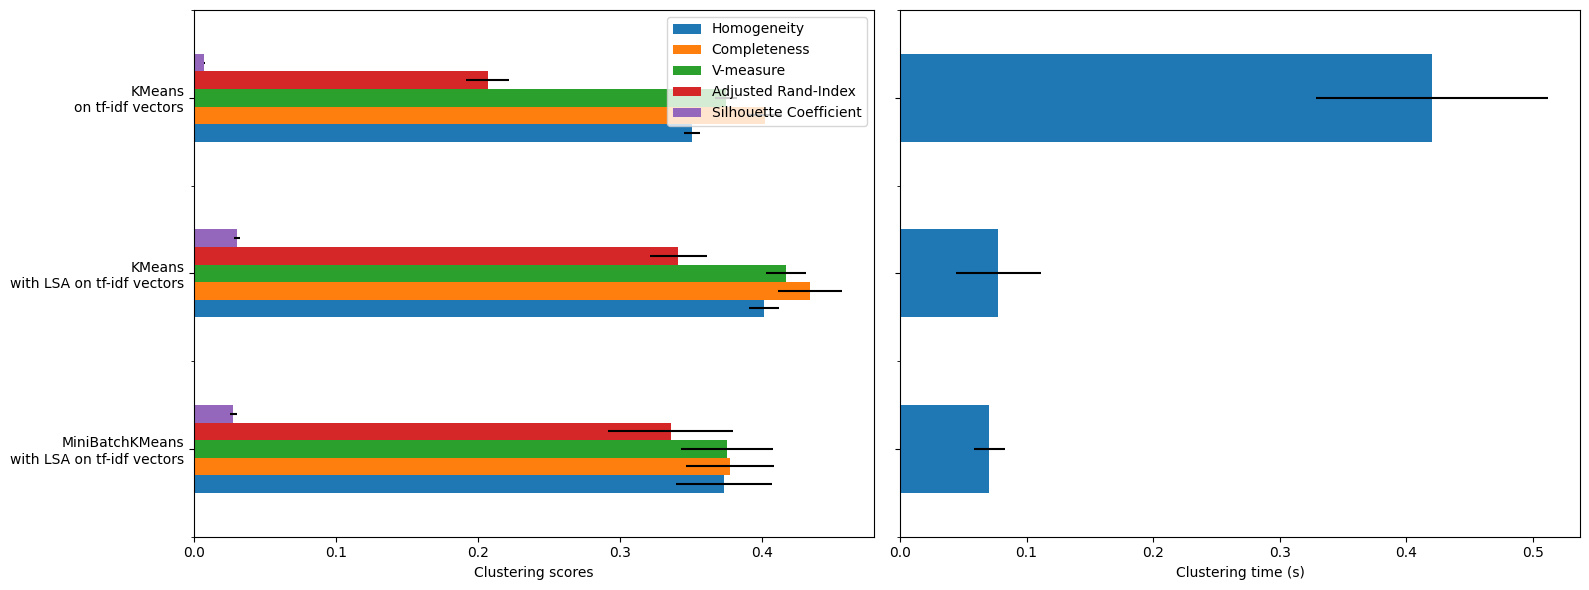

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

KMeans and MiniBatchKMeans suffer from the phenomenon called the Curse of Dimensionality for high dimensional datasets such as text data. That is the reason why the overall scores improve when using LSA. Using LSA reduced data also improves the stability and requires lower clustering time, though keep in mind that the LSA step itself takes a long time.

The size of the error bars show that MiniBatchKMeans is less stable than KMeans for this relatively small dataset. It is more interesting to use when the number of samples is much bigger, but it can come at the expense of a small degradation in clustering quality compared to the traditional k-means algorithm.